In [1]:
import urllib
import csv
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import concat
from pandas import DataFrame
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LightSource
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn import datasets, linear_model
from mintpy.utils import readfile
import numpy as np
import scipy.io as sio
import datetime
from dateutil.relativedelta import relativedelta


In [2]:
def get_basemap(dem_file):
    dem, atr_dem = readfile.read(dem_file)
    geo_box=[1,2,3,4]; 
    geo_box[0]=float(atr_dem['X_FIRST']);geo_box[1]=float(atr_dem['Y_FIRST']);
    geo_box[2]=geo_box[0]+int(atr_dem['WIDTH'])*float(atr_dem['X_STEP']);
    geo_box[3]=geo_box[1]+int(atr_dem['FILE_LENGTH'])*float(atr_dem['Y_STEP']);
    print (geo_box)
    map_projection='cyl';
    ls = LightSource(azdeg=315, altdeg=45)
    dem_shade = ls.shade(dem, vert_exag=1.0, cmap=plt.cm.gray, vmin=-20000, vmax=np.nanmax(dem)+2500)
    return dem_shade,geo_box

def plot_background_dem(dem_file):
    #plot DEM as background
    
    dem_shade, geo_box = get_basemap(dem_file);
    
    mpl.rcParams['figure.figsize'] = (10, 10)
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

    ax.tick_params(labelsize=15)
    ax.tick_params(axis='x',length=15, width=5);
    ax.tick_params(axis='y',length=15, width=5);

    ax.set_aspect('auto')
    
    # Plot DEM using Cartopy
    #           extent=(geo_box[0], geo_box[2], geo_box[1], geo_box[3]))
    ax.imshow(dem_shade, origin='lower', cmap=plt.cm.gray,
              extent=(geo_box[0], geo_box[2], geo_box[1], geo_box[3]))
    # Add coastline
    ax.add_feature(cfeature.COASTLINE, linewidth=2)

    #add lines and faults
    ax.plot(lines['Lllh'][:,0],lines['Lllh'][:,1],color='black', linestyle='dashed',linewidth=2);
    ax.set_ylim(19.27, 19.6)
    ax.set_xlim(-155.79, -155.41)

def get_GPS_vel(sitename,time1,time2):
    filename='data/'+sitename+'.txt'
    dfin = read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']
    dataval=DataFrame(index=index);dataerr=DataFrame(index=index);
    dataval=concat([dfin['YYMMMDD'].rename('date'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                    (dfin['u0(m)']+dfin['____up(m)']).rename('up'),dfin['yyyy.yyyy'].rename('dateval')], axis=1)
    dataerr=concat([dfin['yyyy.yyyy'].rename('date'), dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1, 
                 ignore_index=False);
    dataval['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    dataerr['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    time1 = pd.to_datetime(time1)
    time2 = pd.to_datetime(time2)
    mask= (dataval['date'] > time1) & (dataval['date'] < time2)
    dataval=dataval[mask];dataerr=dataerr[mask];
    regr = linear_model.LinearRegression()
    regr.fit(dataval['dateval'].values.reshape(-1,1),dataval['east'].values.reshape(-1,1));east_vel=regr.coef_[0][0];
    regr.fit(dataval['dateval'].values.reshape(-1,1),dataval['north'].values.reshape(-1,1));north_vel=regr.coef_[0][0];
    regr.fit(dataval['dateval'].values.reshape(-1,1),dataval['up'].values.reshape(-1,1));up_vel=regr.coef_[0][0];
    return east_vel*1000, north_vel*1000,up_vel*1000;

def get_quiver(gpslist,lonlist,latlist,time1,time2):
    #print time1,time2
    u_ref,v_ref,z_ref=get_GPS_vel('MKEA',time1,time2);#print u_ref,v_ref,z_ref
    X,Y,U,V,Z=[],[],[],[],[]      
    for i in range(len(gpslist)):
        try:
            u,v,z=get_GPS_vel(gpslist[i],time1,time2);u=u-u_ref;v=v-v_ref;
            U.append(float(u));V.append(float(v));Z.append(float(z));
            X.append(float(lonlist[i])),Y.append(float(latlist[i]));
        except:
            pass
    return X,Y,U,V,Z

In [3]:
inf=open('data/GPS_BenBrooks_03-05full.txt');next(inf)

reader=csv.reader(inf, delimiter=' ');
zipper=zip(*reader);
gpslist = list(next(zipper))
latlist = list(next(zipper))
lonlist = list(next(zipper))
dem_file='data/demGeo.h5'
dem_shade,geo_box=get_basemap(dem_file)
lines=sio.loadmat('./data/hawaii_lines_new.mat',squeeze_me=True);

[-156.000509259, 20.0005092593, -154.9993981478845, 18.999398148184483]


[-156.000509259, 20.0005092593, -154.9993981478845, 18.999398148184483]
[-156.000509259, 20.0005092593, -154.9993981478845, 18.999398148184483]
[-156.000509259, 20.0005092593, -154.9993981478845, 18.999398148184483]


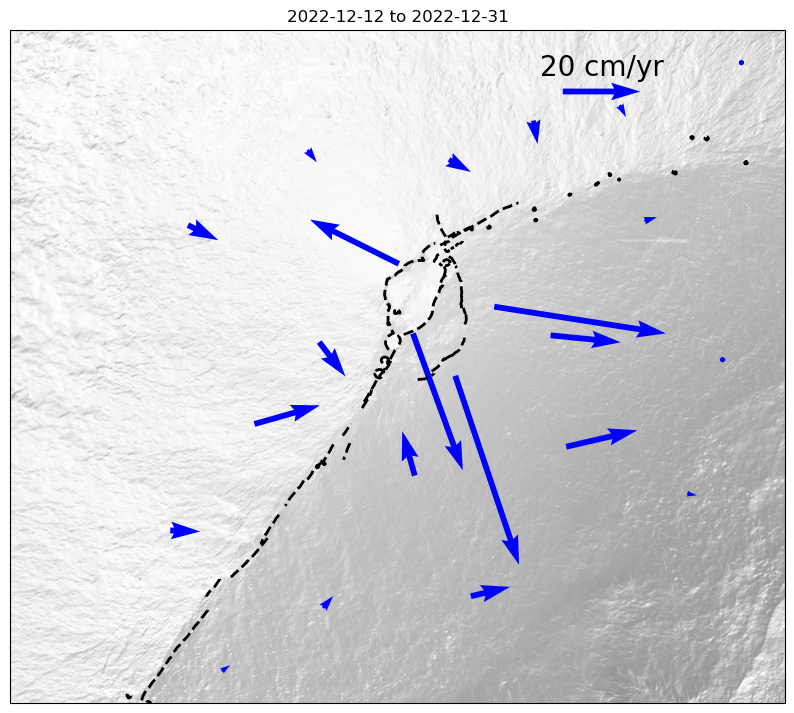

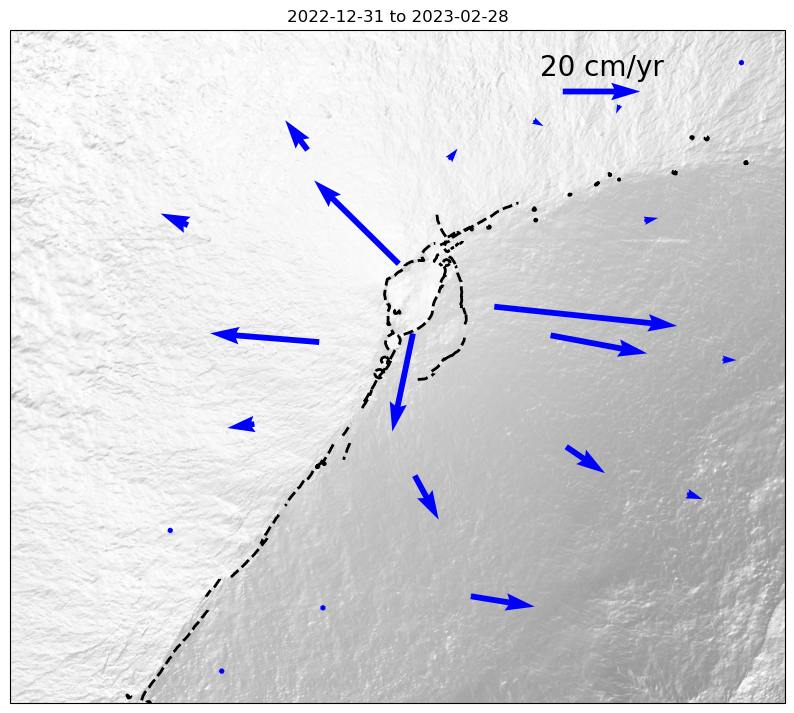

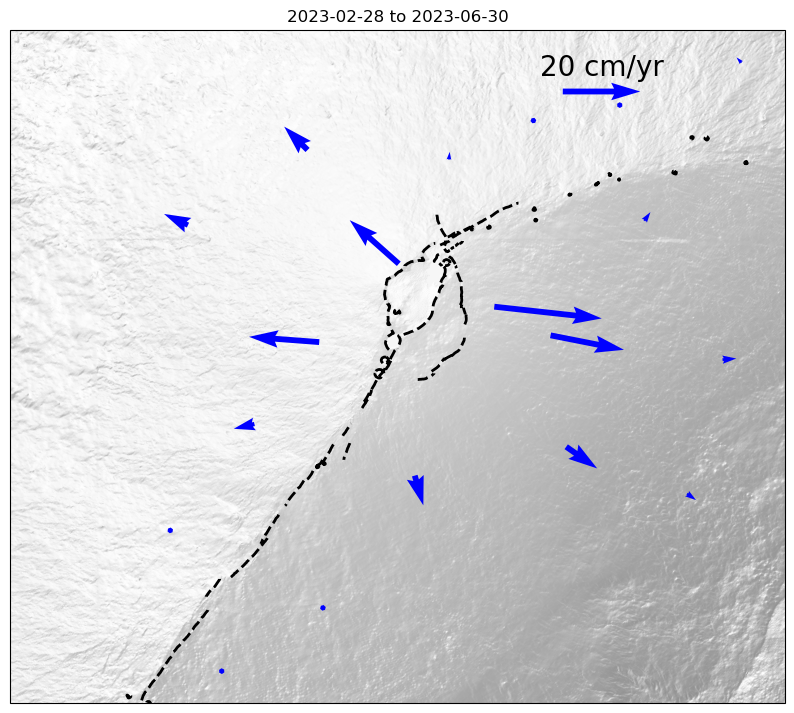

In [4]:
times = [datetime.date(2018, 9, 1), datetime.date(2022, 9, 1), datetime.date(2022, 11, 26),
         datetime.date(2022, 12, 31), datetime.date(2023, 2, 28), datetime.date(2023, 6, 30) ]
scale_list = [5 , 10 , 100 , 50 , 15]; unit_list = ['cm/yr', 'cm/yr', 'cm/yr', 'cm/yr', 'cm/yr' ] 

# Same scale along lower eastern flank
times = [datetime.date(2018, 9, 1), datetime.date(2022, 9, 1), datetime.date(2022, 11, 26), datetime.date(2022, 12, 31)]
scale_list = [5 , 8 ]; unit_list = ['cm/yr', 'cm/yr' ] 
times = [  datetime.date(2022, 12, 12), datetime.date(2022, 12, 31), datetime.date(2023, 2, 28), datetime.date(2023, 6, 30) ] 
scale_list = [ 20, 15, 15 ]; unit_list = [ 'cm/yr',  'cm/yr', 'cm/yr'] 
scale_list = [ 20, 20, 20]; unit_list = [ 'cm/yr',  'cm/yr', 'cm/yr'] 


# times = [datetime.date(2018, 9, 1), datetime.date(2022, 9, 1), datetime.date(2022, 11, 26),
#        datetime.date(2022, 11, 28), datetime.date(2022, 12, 31)] 
# scale_list = [5 , 10 , 100 , 50 ]; unit_list = ['cm/yr', 'cm/yr', 'cm/yr', 'cm/yr'] 

# times = [ datetime.date(2022, 11, 25), datetime.date(2022, 11, 29),  datetime.date(2022, 12, 12),  
#          datetime.date(2023, 2, 28), datetime.date(2023, 6, 30) ] 
# scale_list = [500, 700, 15, 15, 15 ]; unit_list = ['cm', 'cm',  'cm/yr',  'cm/yr'] 

# times = [ datetime.date(2018, 9, 1), datetime.date(2022, 9, 1), datetime.date(2022, 11, 25), 
#          datetime.date(2022, 11, 29), datetime.date(2022, 12, 12) ] 
# scale_list = [5, 10, 2300, 700 ]; unit_list = ['cm/yr', 'cm/yr', 'cm', 'cm' ] 

for i, scale, unit in zip(range(len(times)-1), scale_list, unit_list):
    plot_background_dem(dem_file)
    X,Y,U,V,Z = get_quiver(gpslist,lonlist,latlist,times[i],times[i+1]);
    quiv = plt.quiver(X, Y, U, V, scale = scale*100, color='blue')

    str_title = times[i].strftime("%Y-%m-%d") + ' to ' + times[i+1].strftime("%Y-%m-%d")
    duration_years = relativedelta(times[i+1], times[i]).days/365
    
    if unit == 'cm/yr':
        str_label=str(scale) + ' ' + unit
    if unit == 'cm':
         str_label=str(round(scale * duration_years)) + ' ' + unit

    plt.quiverkey(quiv, -155.50, 19.57, scale*10, str_label,labelpos='N',coordinates='data',
                  color='blue',fontproperties={'size': 20})    
    plt.title(str_title)
# plt.setp(ax.spines.values(), linewidth=3);
#plt.savefig('GPS_vectors_MaunaLoa_2022_2023.pdf',dpi=300,bbox_inches='tight',transparent='True')